# CarND-Behavioral-Cloning-Project-3

In [1]:
import random
import pandas as pd
import numpy as np
import time
import shutil

import os
import cv2
import math
import json
import keras

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook
from keras.preprocessing.image import *
from keras.models import Sequential, Model
from keras.layers import Convolution2D, Flatten, MaxPooling2D, Lambda, ELU
from keras.layers.core import Dense, Dropout, Activation

from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.regularizers import l2
from keras.layers.normalization import BatchNormalization
from IPython.display import display

Using TensorFlow backend.


In [2]:
# Set psuedo-random seed for reproducibility
seed = 7
np.random.seed(seed)

columns = ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed']
data = pd.read_csv('C:/Users/Kirst/Desktop/data/driving_log.csv', names=columns)

print("Dataset Columns:", columns, "\n")

print(data.describe(), "\n")

print("Shape of the dataset:", data.shape, "\n")
print("Data loaded...")

Dataset Columns: ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed'] 

       steering_angle      throttle         brake         speed
count    12560.000000  12560.000000  12560.000000  1.256000e+04
mean        -0.011513      0.110187      0.001398  1.297583e+01
std          0.110524      0.186853      0.030646  3.927478e+00
min         -1.000000      0.000000      0.000000  4.840000e-07
25%         -0.051502      0.000000      0.000000  1.063508e+01
50%          0.000000      0.000000      0.000000  1.208980e+01
75%          0.025751      0.263998      0.000000  1.454101e+01
max          1.000000      1.000000      1.000000  3.010795e+01 

Shape of the dataset: (12560, 7) 

Data loaded...


## Visualize the Dataset
Let's take a look at a histogram of the steering angle attribute.

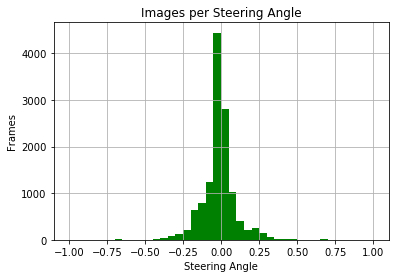

In [3]:
binwidth = 0.05

# Histogram images per steering angle before image augmentation
plt.hist(data.steering_angle,color = "green",bins=np.arange(min(data.steering_angle), max(data.steering_angle) + binwidth, binwidth))
plt.title('Images per Steering Angle')
plt.xlabel('Steering Angle')
plt.ylabel('Frames')
plt.grid(True)
plt.show()

This dataset is biased for a 0.0 steering angle compared with more steering angles to the left and more than half the amount of right steering angles, despite driving the vehicle in both directions to collect the data.

In order to normalize the dataset bias, we need to either obtain more data or create more data. If we obtain more data, we will have to collect and add more data to this dataset, potentially causing even more of a dataset bias and further delay of the project.

Image augmentation will allow us to create new training data from a smaller dataset. By augmenting the data, we can create more data that more accurately depicts what might be encountered in the real world without actually having to collect new images by driving under different driving conditions such as:
    
                                                            * nighttime driving
                                                            * adverse weather
                                                            * heavy traffic
                                                            * driving without road markings


## Shuffle & Partition the Data

Now that we have a visual representation of the steering data, we will shuffle and separate the dataset into two parts: training and validation data. We will set aside 20% of the dataset for validation data while we keep 80% for training data. We won't need to set aside testing data here because the model will be tested and recorded when we allow it to drive autonomously around the track.

In [4]:
# Shuffle the data
# Load randomized datasets for training and validation and split them, 90% and 10%, respectively
data = data.reindex(np.random.permutation(data.index))

num_train = int((len(data) / 10.0) * 8.0)

X_train = data.iloc[:num_train]
X_validation = data.iloc[num_train:]

print("X_train has {} elements.".format(len(X_train)))
print("X_valid has {} elements.".format(len(X_validation)))

X_train has 10048 elements.
X_valid has 2512 elements.


## Configure the Variables

In [5]:
# Variables for Image Augmentation
camera_offset = 0.25 # Will shift the left and right camera images by 0.30 in order to correct for the recording location
channel_shift_range = 0.2 # Will slightly shift image color channel
height_shift_range = 40 # Will shift the height by small increments 
width_shift_range = 100 # Will use the width shifting technique to randomly shift the image in small increments

# Variables for Processed Images
processed_img_rows = 64 # Width of processed image to be scaled to 64 px
processed_img_cols = 64 # Height of processed image to be scaled to 64 px
processed_img_channels = 3 # Train model in color

# Variables for Model Training 
nb_epoch = 7 # Our DNN will be trained for 7 epochs
batch_size = 256 # We will keep the batch size small in order to save room for memory

## Augment the Dataset Images
Here, we define how we will augment the images. Our image processing pipeline follows below.


In [6]:
# Flip dataset images horizontally 
def horizontal_flip(img, steering_angle):
    flipped_image = cv2.flip(img, 1)
    steering_angle = -1 * steering_angle
    return flipped_image, steering_angle

In [7]:
# Shift channels
def channel_shift(img, channel_shift_range=channel_shift_range):
    img_channel_index = 2  # tensorflow indexing
    channel_shifted_image = random_channel_shift(img, channel_shift_range, img_channel_index)
    return channel_shifted_image

In [8]:
# Shift the height and width of the image
def height_width_shift(img, steering_angle):
    rows, cols, channels = img.shape
    
    # Translation
    tx = width_shift_range * np.random.uniform() - width_shift_range / 2
    ty = height_shift_range * np.random.uniform() - height_shift_range / 2
    steering_angle = steering_angle + tx / width_shift_range * 2 * 0.2
    
    transform_matrix = np.float32([[1, 0, tx],
                                   [0, 1, ty]])
    
    translated_image = cv2.warpAffine(img, transform_matrix, (cols, rows))
    return translated_image, steering_angle

In [9]:
# Apply random brightness 
def brightness_shift(img, bright_value=None):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    if bright_value:
        img[:,:,2] += bright_value
    else:
        random_bright = 0.3 + np.random.uniform()
        img[:,:,2] = img[:,:,2] * random_bright
    
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

In [10]:
# Crop 25 pixels from the bottom of the image to remove the car’s hood, while reducing the height of the image
# by 25% to eliminate superfluos data (trees, corridor markings, lakes, shadows, etc.)
def crop_resize_image(img):
    shape = img.shape
    img = img[math.floor(shape[0]/3):shape[0]-25, 0:shape[1]]
    img = cv2.resize(img, (processed_img_cols, processed_img_rows), interpolation=cv2.INTER_AREA)    
    return img

In [11]:
# Wrapper function to take pre-processed images into current transformation
def apply_random_transformation(img, steering_angle):
    
    transformed_image, steering_angle = height_width_shift(img, steering_angle)
    transformed_image = brightness_shift(transformed_image)
    
    if np.random.random() < 0.5:
        transformed_image, steering_angle = horizontal_flip(transformed_image, steering_angle)
            
    transformed_image = crop_resize_image(transformed_image)
    
    return transformed_image, steering_angle

## Visualization of Image Augmentation
It's helpful to see the image augmentation for humans.

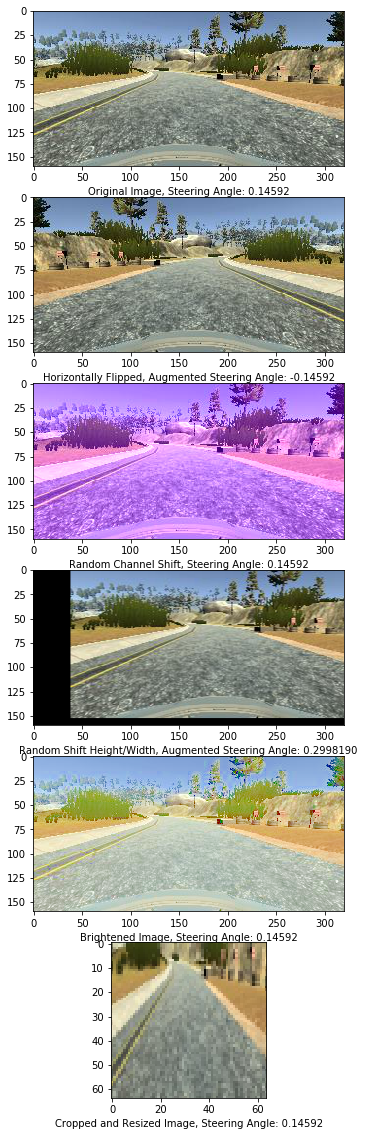

In [12]:
# Read in an image with corresponding steering angle
def read_image(fn):
    img = load_img(fn)
    img = img_to_array(img) 
    return img

test_fn = "C:/Users/Kirst/Desktop/data/IMG/center_2017_11_16_19_13_31_839.jpg"
steering_angle = 0.14592

test_image = read_image(test_fn)

plt.subplots(figsize=(7, 20))

# Original dataset image
plt.subplot(611)
plt.xlabel("Original Image, Steering Angle: " + str(steering_angle))
plt.imshow(array_to_img(test_image))

# Horizontal flip
flipped_image, new_steering_angle = horizontal_flip(test_image, steering_angle)
plt.subplot(612)
plt.xlabel("Horizontally Flipped, Augmented Steering Angle: " + str(new_steering_angle))
plt.imshow(array_to_img(flipped_image))

# Random channel shift
channel_shifted_image = channel_shift(test_image, 255)
plt.subplot(613)
plt.xlabel("Random Channel Shift, Steering Angle: " + str(steering_angle))
plt.imshow(array_to_img(channel_shifted_image))

# Height/Width shift
width_shifted_image, new_steering_angle = height_width_shift(test_image, steering_angle)
new_steering_angle = "{:.7f}".format(new_steering_angle)
plt.subplot(614)
plt.xlabel("Random Shift Height/Width, Augmented Steering Angle: " + str(new_steering_angle))
plt.imshow(array_to_img(width_shifted_image))

# Image brighteness
brightened_image = brightness_shift(test_image, 255)
plt.subplot(615)
plt.xlabel("Brightened Image, Steering Angle: " + str(steering_angle))
plt.imshow(array_to_img(brightened_image))

# Cropped image
cropped_image = crop_resize_image(test_image)
plt.subplot(616)
plt.xlabel("Cropped and Resized Image, Steering Angle: " + str(steering_angle))
_ = plt.imshow(array_to_img(cropped_image))

##  Keras Generator Sub-Sampling
Because the model has a bias towards driving straight, we can use Kera's generator function to sample images that possess lower steering angles to have a lower probability of being represented in the image dataset. 

The function will load csv file line and will randomly load images from either the left, right or center images. After that, the image augmentations funtions will be applied and a transformed image and corresponding steering angle will be notated.



In [13]:
# Load and augment pseudo-random dataset images and provide new steering angle dimensions
def load_and_augment_image(line_data):
    i = np.random.randint(3)
    
    if (i == 0):
        path_file = line_data['left'][0].strip()
        shift_angle = camera_offset
    elif (i == 1):
        path_file = line_data['center'][0].strip()
        shift_angle = 0.
    elif (i == 2):
        path_file = line_data['right'][0].strip()
        shift_angle = -camera_offset
        
    steering_angle = line_data['steering_angle'][0] + shift_angle
    
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, steering_angle = apply_random_transformation(img, steering_angle)
    return img, steering_angle

## Make Keras Generator Threadsafe
Keras generators are not thread-safe for unintended interactions in multi-threaded code so we must wrap our iterator/generator in a thread-safe class.
https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html

In [14]:
# Keras generators are not thread-safe 
class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self
    
    def __next__(self):
        with self.lock:
            return self.it.__next__()
        
def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

## The Keras Generator


In [15]:
generated_steering_angles = []# The threshold variable drops out dataset images that have smaller angles
threshold = 1

@threadsafe_generator
def generate_batch_data(_data, batch_size = 32):
    
    batch_images = np.zeros((batch_size, processed_img_rows, processed_img_cols, processed_img_channels))
    batch_steering = np.zeros(batch_size)
    
    while 1:
        for batch_index in range(batch_size):
            row_index = np.random.randint(len(_data))
            line_data = _data.iloc[[row_index]].reset_index()
            keep = 0
            while keep == 0:
                x, y = load_and_augment_image(line_data)
                if abs(y) < .1:
                    val = np.random.uniform()
                    if val > threshold: 
                        keep = 1
                else:
                    keep = 1 # Will dropout dataset images with low angle values close to zero that replicate the model
                            # having a bias toward driving only straight
            
            batch_images[batch_index] = x
            batch_steering[batch_index] = y
            generated_steering_angles.append(y)
        yield batch_images, batch_steering

## Augmented Images - Samples
Our image-preprocessing pipeline will be fed to our DNN as training images. Let's have a look!

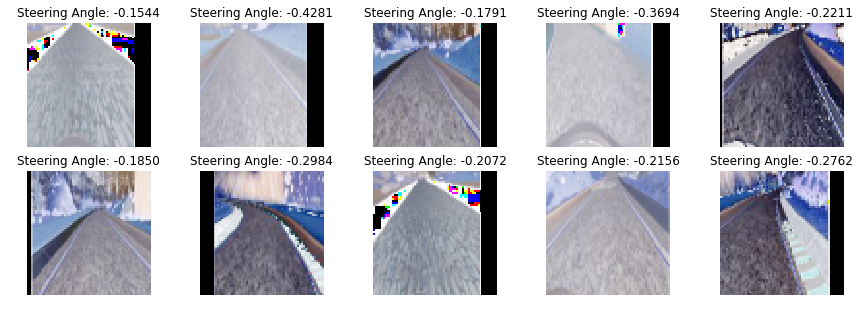

In [16]:
# Show pre-possed images to be fed into our DNN
iterator = generate_batch_data(X_train, batch_size=10)
sample_images, sample_steerings = iterator.__next__()

plt.subplots(figsize=(15, 5))
for i, img in enumerate(sample_images):
    plt.subplot(2, 5, i+1)
    plt.title("Steering Angle: {:.4f}".format(sample_steerings[i]))
    plt.axis('off')
    plt.imshow(img)
plt.show()

## Model Architecture = comma.ai model
Because we needed to find a light-weight solution after experiencing many delays (and a high AWS monetary expense) between Windows 10 and AWS, filepaths, Keras and Tensorflow, we tried both the nvidia model http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf and comma.ai modelhttps://github.com/commaai/research/blob/master/train_steering_model.py. While both seemed to work adequately, we settled on the comma.ai model because of its smaller parameter size, and the fact that it has a lower processing latency, something we wanted to try on Windows 10 environment.https://github.com/commaai/research/blob/master/train_steering_model.py

Udacity provided a dataset consisting of image files and a csv file. We loaded the csv file into pandas, then shuffled and split the data into two sets: training and validation. 

In [17]:
model = Sequential()
model.add(Lambda(lambda x: (x/127.5 - 1.), input_shape=(processed_img_rows, processed_img_cols, processed_img_channels)))
model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same", activation='elu', name='Conv1'))
model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same", activation='elu', name='Conv2'))
model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same", activation='elu', name='Conv3'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(ELU())
model.add(Dense(512, activation='elu', name='FC1'))
model.add(Dropout(0.5))
model.add(ELU())
model.add(Dense(1, name='output'))
model.summary()

# Compile the Model
opt = Adam(lr=0.0001) # Learning rate
model.compile(optimizer=opt, loss='mse', metrics=[])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
Conv1 (Convolution2D)            (None, 16, 16, 16)    3088        lambda_1[0][0]                   
____________________________________________________________________________________________________
Conv2 (Convolution2D)            (None, 8, 8, 32)      12832       Conv1[0][0]                      
____________________________________________________________________________________________________
Conv3 (Convolution2D)            (None, 4, 4, 64)      51264       Conv2[0][0]                      
___________________________________________________________________________________________

## Fit the Model
We want to improve sample images with lower steer angles that have a lower probability of representation in the dataset by eliminating them with a lower probability.

In [18]:
class LifecycleCallback(keras.callbacks.Callback):

    def on_epoch_begin(self, epoch, logs={}):
        pass

    def on_epoch_end(self, epoch, logs={}):
        global threshold
        threshold = 1 / (epoch + 1)

    def on_batch_begin(self, batch, logs={}):
        pass

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

    def on_train_begin(self, logs={}):
        print('Begin Training Session...')
        self.losses = []

    def on_train_end(self, logs={}):
        print('End Training Session')
        
def calc_samples_per_epoch(array_size, batch_size):
    num_batches = array_size / batch_size
    samples_per_epoch = math.ceil(num_batches)
    samples_per_epoch = samples_per_epoch * batch_size
    return samples_per_epoch

## Train the Data

In [19]:
# Train the Data
lifecycle_callback = LifecycleCallback()       

train_generator = generate_batch_data(X_train, batch_size)
validation_generator = generate_batch_data(X_validation, batch_size)

samples_per_epoch = calc_samples_per_epoch((len(X_train)*3), batch_size)
nb_val_samples = calc_samples_per_epoch((len(X_validation)*3), batch_size)

history = model.fit_generator(train_generator, 
                              validation_data = validation_generator,
                              samples_per_epoch = samples_per_epoch, 
                              nb_val_samples = nb_val_samples,
                              nb_epoch = nb_epoch, verbose=1,
                              callbacks=[lifecycle_callback])

Begin Training Session...
Epoch 1/7
30208/30208 [==============================] - ETA: 1108s - loss: 0.13 - ETA: 994s - loss: 0.1172 - ETA: 931s - loss: 0.113 - ETA: 967s - loss: 0.111 - ETA: 928s - loss: 0.108 - ETA: 905s - loss: 0.107 - ETA: 877s - loss: 0.104 - ETA: 855s - loss: 0.104 - ETA: 833s - loss: 0.104 - ETA: 824s - loss: 0.102 - ETA: 806s - loss: 0.100 - ETA: 792s - loss: 0.099 - ETA: 778s - loss: 0.098 - ETA: 763s - loss: 0.098 - ETA: 744s - loss: 0.097 - ETA: 727s - loss: 0.096 - ETA: 709s - loss: 0.095 - ETA: 698s - loss: 0.095 - ETA: 687s - loss: 0.094 - ETA: 675s - loss: 0.093 - ETA: 666s - loss: 0.093 - ETA: 652s - loss: 0.093 - ETA: 640s - loss: 0.092 - ETA: 627s - loss: 0.091 - ETA: 615s - loss: 0.090 - ETA: 604s - loss: 0.089 - ETA: 595s - loss: 0.088 - ETA: 585s - loss: 0.088 - ETA: 576s - loss: 0.087 - ETA: 568s - loss: 0.087 - ETA: 558s - loss: 0.086 - ETA: 549s - loss: 0.086 - ETA: 539s - loss: 0.086 - ETA: 530s - loss: 0.085 - ETA: 519s - loss: 0.085 - ETA: 5

30208/30208 [==============================] - ETA: 37s - loss: 0.05 - ETA: 37s - loss: 0.05 - ETA: 36s - loss: 0.05 - ETA: 36s - loss: 0.05 - ETA: 36s - loss: 0.05 - ETA: 35s - loss: 0.05 - ETA: 35s - loss: 0.05 - ETA: 34s - loss: 0.05 - ETA: 34s - loss: 0.05 - ETA: 33s - loss: 0.05 - ETA: 38s - loss: 0.05 - ETA: 53s - loss: 0.05 - ETA: 67s - loss: 0.05 - ETA: 79s - loss: 0.05 - ETA: 88s - loss: 0.05 - ETA: 96s - loss: 0.05 - ETA: 103s - loss: 0.054 - ETA: 109s - loss: 0.054 - ETA: 113s - loss: 0.054 - ETA: 118s - loss: 0.054 - ETA: 121s - loss: 0.054 - ETA: 125s - loss: 0.054 - ETA: 126s - loss: 0.054 - ETA: 128s - loss: 0.054 - ETA: 131s - loss: 0.054 - ETA: 132s - loss: 0.054 - ETA: 134s - loss: 0.054 - ETA: 135s - loss: 0.054 - ETA: 136s - loss: 0.054 - ETA: 136s - loss: 0.054 - ETA: 136s - loss: 0.054 - ETA: 136s - loss: 0.053 - ETA: 138s - loss: 0.054 - ETA: 138s - loss: 0.054 - ETA: 138s - loss: 0.054 - ETA: 138s - loss: 0.054 - ETA: 137s - loss: 0.054 - ETA: 136s - loss: 0.053

30208/30208 [==============================] - ETA: 30s - loss: 0.05 - ETA: 31s - loss: 0.05 - ETA: 32s - loss: 0.05 - ETA: 33s - loss: 0.05 - ETA: 32s - loss: 0.04 - ETA: 32s - loss: 0.04 - ETA: 33s - loss: 0.04 - ETA: 32s - loss: 0.04 - ETA: 32s - loss: 0.04 - ETA: 32s - loss: 0.04 - ETA: 37s - loss: 0.04 - ETA: 50s - loss: 0.04 - ETA: 62s - loss: 0.04 - ETA: 70s - loss: 0.04 - ETA: 78s - loss: 0.04 - ETA: 84s - loss: 0.04 - ETA: 90s - loss: 0.04 - ETA: 94s - loss: 0.04 - ETA: 98s - loss: 0.04 - ETA: 101s - loss: 0.048 - ETA: 104s - loss: 0.048 - ETA: 106s - loss: 0.048 - ETA: 108s - loss: 0.048 - ETA: 110s - loss: 0.048 - ETA: 112s - loss: 0.048 - ETA: 113s - loss: 0.048 - ETA: 114s - loss: 0.048 - ETA: 114s - loss: 0.048 - ETA: 115s - loss: 0.048 - ETA: 115s - loss: 0.048 - ETA: 115s - loss: 0.048 - ETA: 115s - loss: 0.048 - ETA: 115s - loss: 0.048 - ETA: 115s - loss: 0.048 - ETA: 115s - loss: 0.048 - ETA: 114s - loss: 0.048 - ETA: 114s - loss: 0.048 - ETA: 114s - loss: 0.048 - ETA

30208/30208 [==============================] - ETA: 36s - loss: 0.04 - ETA: 36s - loss: 0.04 - ETA: 36s - loss: 0.04 - ETA: 36s - loss: 0.04 - ETA: 35s - loss: 0.04 - ETA: 36s - loss: 0.04 - ETA: 36s - loss: 0.04 - ETA: 36s - loss: 0.04 - ETA: 36s - loss: 0.04 - ETA: 36s - loss: 0.04 - ETA: 41s - loss: 0.04 - ETA: 54s - loss: 0.04 - ETA: 66s - loss: 0.04 - ETA: 75s - loss: 0.04 - ETA: 84s - loss: 0.04 - ETA: 91s - loss: 0.04 - ETA: 97s - loss: 0.04 - ETA: 102s - loss: 0.048 - ETA: 107s - loss: 0.048 - ETA: 110s - loss: 0.048 - ETA: 113s - loss: 0.048 - ETA: 117s - loss: 0.047 - ETA: 118s - loss: 0.048 - ETA: 119s - loss: 0.048 - ETA: 121s - loss: 0.048 - ETA: 122s - loss: 0.047 - ETA: 123s - loss: 0.047 - ETA: 123s - loss: 0.047 - ETA: 124s - loss: 0.047 - ETA: 124s - loss: 0.047 - ETA: 124s - loss: 0.047 - ETA: 124s - loss: 0.047 - ETA: 124s - loss: 0.047 - ETA: 124s - loss: 0.047 - ETA: 124s - loss: 0.047 - ETA: 124s - loss: 0.047 - ETA: 124s - loss: 0.047 - ETA: 123s - loss: 0.047 -

## Conclusion
The average time per epoch was significantly reduced using this deep neural network (DNN) model without compromising quality or time. We used this code on a HP Envy Desktop 750-167c with a 6th generation Intel Core is-6400 processor and 12 GB DDR 3L system memory with a 1TB hard drive. We saved a lot of money by discontinuing AWS and using this model instead.

## Save the Model
Below, we save the model, weights and architecture.

In [20]:
from keras.models import load_model

model_json = model.to_json()
with open("./model.json", "w") as json_file:
    json.dump(model_json, json_file)
    
model.save_weights("./model.h5")
print("Saved Model to Disk")

Saved Model to Disk


## Analysis

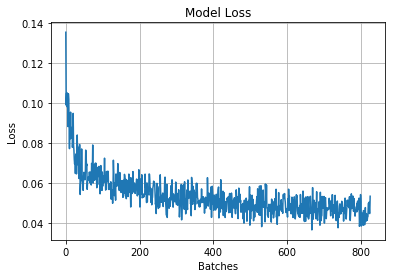

In [21]:
# Summarize history for batch loss
batch_history = lifecycle_callback.losses
plt.plot(batch_history)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Batches')
plt.grid(True)
plt.show()

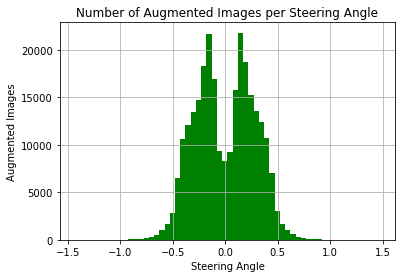

In [22]:
plt.hist(generated_steering_angles, color = "green", bins=np.arange(min(generated_steering_angles), max(generated_steering_angles) + binwidth, binwidth))
plt.title('Number of Augmented Images per Steering Angle')
plt.xlabel('Steering Angle')
plt.ylabel('Augmented Images')
plt.grid(True)
plt.show()



## Histogram

dict_keys(['val_loss', 'loss'])


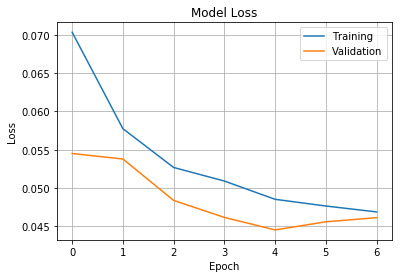

In [23]:
# List all data in history
print(history.history.keys())

# Histogram of epoch loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In this graph, we can see that the training and validation loss decreased over the 8 training epochs. This graph clearly shows that our model did not overfit the data. The model should work well on both driving tracks. Let's check it out!

## Final Test on Autonomous Model
